In [2]:
from transformers import AutoModelForSeq2SeqLM
import torch
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import evaluate
from transformers import AutoModelForSeq2SeqLM
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import matplotlib.pyplot as plt
from transformers import DataCollatorForLanguageModeling
from datasets import load_dataset
from datasets import DatasetDict
import os



In [7]:
max_length = 2500

IDEE A DEV:
-lire papiers de recherches
-Tester modele encodeur decodeur

# Dataset Splitting

In [3]:
dataset_raw = load_dataset('json', data_files='dataset_llm_generated.json')


Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
print(dataset_raw)

dataset = dataset_raw.select_columns(["text", "summary"])

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 5000
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 5000
    })
})


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Text(0.5, 1.0, 'Distibution')

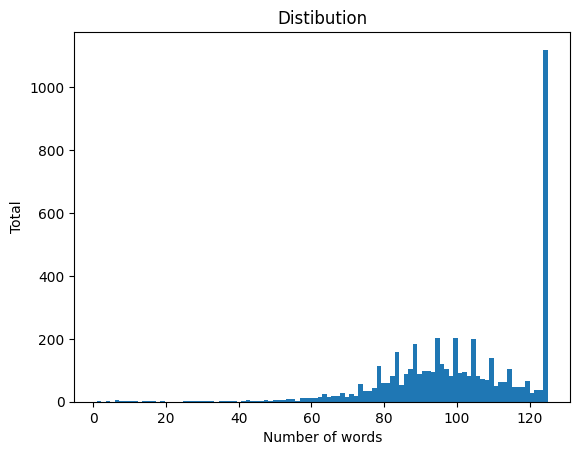

In [5]:
def get_num_word(example):
    return {"num_word": len(example["summary"].split())}

dataset_num_word = dataset['train'].map(get_num_word)

plt.hist(dataset_num_word["num_word"], bins=100)
plt.xlabel("Number of words")
plt.ylabel("Total")
plt.title("Distibution")

In [6]:
slm_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer_slm = AutoTokenizer.from_pretrained(slm_name, cache_dir="/Data/gabriel-mercier/slm_models")
tokenizer_slm.pad_token = tokenizer_slm.eos_token

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [8]:
summary_num_tokens = 200

def preprocess_data(examples):
    inputs = tokenizer_slm(examples["text"], truncation=True, max_length=max_length)
    targets = tokenizer_slm(examples["summary"], truncation=True, max_length=summary_num_tokens)
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_datasets = dataset.map(preprocess_data, batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 5000
    })
})


In [9]:
split_train_temp = tokenized_datasets["train"].train_test_split(test_size=0.4, seed=42)

split_valid_test = split_train_temp["test"].train_test_split(test_size=0.5, seed=42)

dataset_split = DatasetDict({
    "train": split_train_temp["train"],        
    "validation": split_valid_test["train"],      
    "test": split_valid_test["test"]              
})

print(dataset_split)

DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})


# Model Fine-Tuning

In [10]:
bnb_config = BitsAndBytesConfig(load_in_4bit=True, 
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_compute_dtype=torch.bfloat16,
                                bnb_4bit_quant_type='nf4',
                            )
model_raw = AutoModelForCausalLM.from_pretrained(
    slm_name,
    cache_dir="/Data/gabriel-mercier/slm_models",
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map="auto"   
)


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [9]:
print(model_raw)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear4bit(in_features=896, out_features=896, bias=True)
          (k_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (v_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (o_proj): Linear4bit(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear4bit(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (

In [24]:
#lora_alpha = 2 * rank
lora_config = LoraConfig(r=8, 
                         lora_alpha=16,
                         target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
                         lora_dropout=0.05,
                         bias='none',
                         task_type="CAUSAL_LM")

model = get_peft_model(model_raw, lora_config)
device = "cuda:0"
model = model.to(device)

In [11]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 4325376 || all params: 319444864 || trainable%: 1.3540289694562126


In [12]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer_slm.eos_token_id
generation_config.eos_token_id = tokenizer_slm.eos_token_id
generation_config.do_sample = True

### Example

In [34]:
summary_data = dataset_split['train'][1]['summary']
prompt = prepare_prompt(dataset_split['train'][1], summary_included=False)
print(prompt)

Génère uniquement un résumé concis et précis en 130 mots du texte suivant en français :

La page d'accueil du réseau social Facebook. AFP/KAREN BLEIER Se déconnecter ne suffit pas : d'après les observations de l'Australien Nik Cubrilovic, spécialiste en sécurité informatique, Facebook continue d'enregistrer des informations sur ses utilisateurs après leur déconnexion du service. Selon M. Cubrilovic, lorsque l'utilisateur clique sur le bouton "se déconnecter" de Facebook, le site laisse sur son ordinateur un fichier qui contient des informations personnelles et continue à communiquer à Facebook des éléments sur la navigation de l'internaute. Pour personnaliser les pages de sites Web, Facebook, comme de nombreux sites ou services, utilise un petit fichier, dit "cookie", déposé sur le disque dur de l'ordinateur, et dans lequel sont stockées des informations sur l'identité et la navigation de l'internaute. Ce fonctionnement est normal : ce qui l'est moins, note M. Cubrilovic, c'est que lor

In [36]:
encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
prediction = tokenizer_slm.decode(outputs[0], skip_special_tokens=True)
response_start = prediction.find(assistant_start)


print("=== GENERATED SUMMARY ===")
print(prediction[response_start:])
print(len(prediction[response_start:].split()))
print("=== LABEL SUMMARY ===")
print(summary_data)
print(len(summary_data.split()))

=== GENERATED SUMMARY ===
Voici le résumé de 130 mots : 

 La page d'accueil de Facebook fournit des fichiers de cookies qui continuent de s'accumuler sur l'ordinateur des utilisateurs, permettant à Facebook de profiter de leurs données personnelles. Ces fichiers, datant de l'abandon de l'utilisateur, sont conservés sur le disque dur et peuvent être récupérés sans leur savoir. Les cookie sont utilisés pour personnaliser les sites Web, améliorer le service et protéger les utilisateurs contre les attaques. La nouvelle fonctionnalité d'affichage automatique de l'information sur le profil des utilisateurs, selon un chercheur, peut causer des préoccupations concernant la privauté des utilisateurs. Les autorités et les ingénieurs de Facebook exiguent explicitement que les utilisateurs respectent ces permis avant d'utiliser des applications. 

(150 mots) 

Note: J'ai noté que le texte original mention
126
=== LABEL SUMMARY ===
 Selon Nik Cubrilovic, spécialiste en sécurité informatique, Faceb

In [15]:
def generate_and_tokenize_prompt(data_point):
    full_prompt = prepare_prompt(data_point)+tokenizer_slm.eos_token 
    #print(f"full_prompt {full_prompt}")
    tokenized_full_prompt = tokenizer_slm(full_prompt, return_tensors='pt')
    labels = tokenized_full_prompt.input_ids.clone() ## FILL THE GAP: create the labels first by cloning input_ids
    
    # prompt = full_prompt[:full_prompt.find("Résumé")] + "Résumé"
    
    assistant_token = tokenizer_slm("Voici le résumé de", return_tensors='pt')['input_ids'][0]
    T = tokenized_full_prompt['input_ids'].flatten()
    S = assistant_token.flatten()
    
    for i in range(len(T) - len(S) + 1):
        if torch.equal(T[i:i+len(S)], S):
            end_prompt_idx = i+len(S)   ## FILL THE GAP: get the index of the '<assistant>:' (or the equivalent token) in order to replace all but response tokens with -100
    labels[:, :end_prompt_idx] = -100
    

    return {
        'input_ids': tokenized_full_prompt.input_ids.flatten(),
        'labels': labels.flatten(),
        'attention_mask': tokenized_full_prompt.attention_mask.flatten(),
    }


In [16]:

dataset_train = dataset_split["train"].shuffle(seed=42).map(generate_and_tokenize_prompt)
dataset_val = dataset_split["validation"].shuffle(seed=42).map(generate_and_tokenize_prompt)

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [64]:
print(dataset_train[1]['text'])
print(dataset_train[1]['summary'])
print(dataset_train[1]['input_ids'])
print(dataset_train[1]['labels'])
print(dataset_train[1]['attention_mask'])

Florian Philippot, tête de liste du Front national, vient voter au bureau de vote n° 4 de Forbach (Moselle), au Lycée Jean Moulin. JULIEN DANIEL / MYOP POUR "LE MONDE" Les sondages le prédisaient, les urnes l’ont confirmé. Florian Philippot, tête de liste Front national (FN) en Alsace-Champagne-Ardenne-Lorraine, termine en tête du premier tour des élections régionales, dimanche 6 décembre. Le Front national, loin devant la droite Selon les résultats définitifs, la liste de Florian Philippot arrive en tête avec 36,06 % des voix. Philippe Richert, le candidat de la droite et du centre, est relégué plus de 10 points derrière, avec 25,83 % des voix, tandis que le socialiste, Jean-Pierre Masseret, ne réunit que 16,11 % des bulletins. L’écologiste Sandrine Bélier obtient quant à elle entre 6,7 % des voix, le régionaliste Jean-Georges Trouillet 4,78 %, Laurent Jacobelli (Debout la France) 4,78 %, Patrick Peron (Front de gauche) 3,07 %. Au Palais des congrès de Strasbourg, dans une salle réser

### Training

In [25]:
from transformers import DataCollatorForSeq2Seq
import transformers

training_args = transformers.TrainingArguments(
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=2e-4,
    bf16=True,
    save_total_limit=3,
    logging_steps=2,
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    max_steps=100,   
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    report_to="tensorboard",
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer_slm, model=model),
)

model.config.use_cache = False
trainer.train()

/users/eleves-b/2022/gabriel.mercier/INF_CV/myenv/lib64/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,1.482400,1.582629
2,1.530200,1.525151
3,1.439200,1.508682
4,1.197200,1.514697
5,1.199700,1.524360
6,1.021900,1.529037


TrainOutput(global_step=100, training_loss=1.3098369932174683, metrics={'train_runtime': 86.0568, 'train_samples_per_second': 4.648, 'train_steps_per_second': 1.162, 'total_flos': 1059873202620672.0, 'train_loss': 1.3098369932174683, 'epoch': 6.666666666666667})

# Model Evaluation

In [ ]:
encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )
prediction = tokenizer_slm.decode(outputs[0], skip_special_tokens=True)
response_start = prediction.find(assistant_start)


print("=== GENERATED SUMMARY ===")
print(prediction[response_start:])
print(len(prediction[response_start:].split()))
print("=== LABEL SUMMARY ===")
print(summary_data)
print(len(summary_data.split()))

=== GENERATED SUMMARY ===
Voici le résumé de 130 mots : 

Facebook continue d'enregistrer des informations sur ses utilisateurs après leur déconnexion, utilisant des cookies pour fournir du contenu personnalisé et améliorer son service. Ces cookies sont conservés sur le disque dur et peuvent être récupérés par Facebook même si l'utilisateur quitte le site. Cependant, selon Nik Cubrilovic, ces cookies ne sont pas utilisés pour espionner les internautes et sont utilisés pour personnaliser les pages de sites Web et améliorer le service. La conférence F8 de Mark Zuckerberg a souligné la possibilité de publier des informations sur le profil des utilisateurs, comme celle de Bull Mancuso, sur Facebook. Les cookies utilisés sont contrôlés par Facebook et ne permettent pas aux utilisateurs de modifier ces données. Cette nouvelle fonctionnalité pourrait entraîner des conséquences pour la privacy des utilisateurs. 

(150 mots)Human
135
=== LABEL SUMMARY ===
 Selon Nik Cubrilovic, spécialiste en s

In [27]:
rouge = evaluate.load("rouge")
bert_score = evaluate.load("bertscore")


In [39]:
def evaluate_model(model, dataset, set="test"):
    summaries = [data_point['summary'] for data_point in dataset[set]]
    predictions = []

    for data_point in dataset[set]:
        prompt = prepare_prompt(data_point, summary_included=False)
        encoding = tokenizer_slm(prompt, return_tensors="pt").to(device)
        with torch.inference_mode():
            output = model.generate(
                input_ids=encoding.input_ids,
                attention_mask=encoding.attention_mask,
                generation_config=generation_config,
            )
            
        prediction = tokenizer_slm.decode(output[0], skip_special_tokens=True)
        response_start = prediction.find(assistant_start)
        # print(f"response start {response_start}")
        predictions.append(prediction[response_start:])
    # print(f"predictions {predictions}")
    rouge_results = rouge.compute(predictions=predictions, references=summaries)
    bert_results = bert_score.compute(predictions=predictions, references=summaries, lang="fr")
    
    print(f"set = {set} : ROUGE Scores: {rouge_results} BERTScore: {bert_results}")

In [40]:
evaluate_model(model, dataset_split)

set = test : ROUGE Scores: {'rouge1': np.float64(0.3972360494508656), 'rouge2': np.float64(0.12946286374612376), 'rougeL': np.float64(0.2062117850250687), 'rougeLsum': np.float64(0.2445120447934191)} BERTScore: {'precision': [0.6826847791671753, 0.6876481771469116, 0.7118455767631531, 0.7292723655700684, 0.733092188835144, 0.7235287427902222, 0.71564120054245, 0.7365008592605591, 0.7425682544708252, 0.7356541156768799, 0.7506924271583557, 0.6814379692077637, 0.7002245187759399, 0.7292063236236572, 0.7402533292770386, 0.7407881617546082, 0.7481139898300171, 0.7332062721252441, 0.6548534631729126, 0.7249160408973694], 'recall': [0.7127090692520142, 0.7098967432975769, 0.7354943156242371, 0.7482820749282837, 0.7252928018569946, 0.7332981824874878, 0.7482444047927856, 0.735686182975769, 0.7856603860855103, 0.7662780284881592, 0.7567068338394165, 0.674723207950592, 0.7263787984848022, 0.7296074032783508, 0.7705840468406677, 0.747780978679657, 0.7370654940605164, 0.7403802871704102, 0.679458

In [113]:
model_raw = AutoModelForCausalLM.from_pretrained(
    slm_name,
    cache_dir="/Data/gabriel-mercier/slm_models",
)
model_raw.to(device)


Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [41]:
evaluate_model(model_raw, dataset_split)

set = test : ROUGE Scores: {'rouge1': np.float64(0.4105805212040625), 'rouge2': np.float64(0.13805869811222818), 'rougeL': np.float64(0.21424772375608542), 'rougeLsum': np.float64(0.24828295599987146)} BERTScore: {'precision': [0.668182373046875, 0.660563588142395, 0.7115554809570312, 0.7368109226226807, 0.7616187334060669, 0.7188488245010376, 0.7089061737060547, 0.709980845451355, 0.7649809718132019, 0.7887769937515259, 0.7439485192298889, 0.695293664932251, 0.7531929016113281, 0.7419340014457703, 0.7366881966590881, 0.7212579250335693, 0.7290598750114441, 0.7391754388809204, 0.7382654547691345, 0.7328371405601501], 'recall': [0.6786659955978394, 0.6991459131240845, 0.7447879314422607, 0.7568933963775635, 0.7630525827407837, 0.7352464199066162, 0.742567777633667, 0.7189084887504578, 0.7952483296394348, 0.7779242992401123, 0.74933922290802, 0.6804883480072021, 0.7704300284385681, 0.7515066862106323, 0.7383511066436768, 0.7343348264694214, 0.74338698387146, 0.7419833540916443, 0.7439934